In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
from tensorflow.keras.datasets import cifar10
import numpy as np
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
print(x_train.shape)
x_train = x_train/255.
x_test = x_test/255.

num_classes = 10 

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

(50000, 32, 32, 3)


In [3]:
def residual_block(X, f, filters, stage, block, reduce=False, s=2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    if reduce:
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    else: 
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
    
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

   
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X



In [4]:
def ResNet25(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = residual_block(X, 3, [64, 64, 256], stage=2, block='a', reduce=True, s=1)
    X = residual_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = residual_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3 
    X = residual_block(X, 3, [128, 128, 512], stage=3, block='a', reduce=True, s=2)
    X = residual_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = residual_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = residual_block(X, 3, [128, 128, 512], stage=3, block='d')


        
    # AVGPOOL 
    X = AveragePooling2D((1,1), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X= Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [5]:
model = ResNet25(input_shape = (32,32, 3), classes = 10)

In [6]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 13, 13, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 13, 13, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 13, 13, 64)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler=ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


hist = model.fit(x_train, y_train, batch_size=128, epochs=50,
          validation_data=(x_test, y_test), callbacks=[lr_scheduler])


Epoch 1/50
391/391 [==============================] - 99s 246ms/step - loss: 3.2830 - accuracy: 0.2943 - val_loss: 2.3175 - val_accuracy: 0.2906
Epoch 2/50
391/391 [==============================] - 127s 325ms/step - loss: 1.7164 - accuracy: 0.4895 - val_loss: 2.0274 - val_accuracy: 0.3844
Epoch 3/50
391/391 [==============================] - 113s 289ms/step - loss: 1.4401 - accuracy: 0.5576 - val_loss: 2.1532 - val_accuracy: 0.3112
Epoch 4/50
391/391 [==============================] - 124s 317ms/step - loss: 1.3965 - accuracy: 0.5699 - val_loss: 28.1808 - val_accuracy: 0.1499
Epoch 5/50
391/391 [==============================] - 131s 336ms/step - loss: 1.2333 - accuracy: 0.6252 - val_loss: 2.8193 - val_accuracy: 0.3525
Epoch 6/50
391/391 [==============================] - 114s 292ms/step - loss: 1.1204 - accuracy: 0.6554 - val_loss: 1.1709 - val_accuracy: 0.5952
Epoch 7/50
391/391 [==============================] - 127s 324ms/step - loss: 0.9775 - accuracy: 0.6939 - val_loss: 1.8846 -

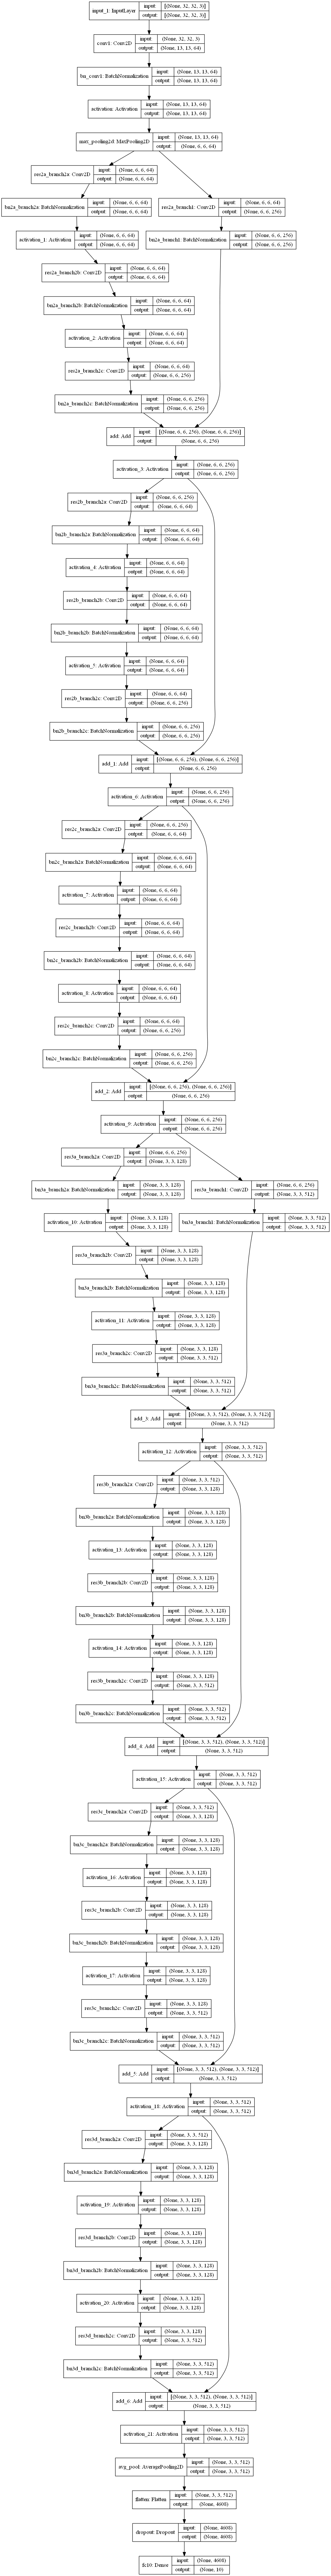

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="images/resnet50.png", show_shapes=True)